<a href="https://colab.research.google.com/github/1mah1/DT2/blob/main/SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install img2vec-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [9]:
import os
from img2vec_pytorch import Img2Vec
from skimage.transform import resize
from skimage.io import imread
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
from sklearn.metrics import log_loss

In [3]:
img2vec = Img2Vec()
input_dir = "/content/drive/MyDrive/Python/garbage_classification"
# categories = ['cardboard', 'green-glass', 'metal', 'plastic']
categories = ['cardboard', 'green-glass', 'metal']
image_size = 224

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.3MB/s]


In [4]:
# Read the data

# data = {}
labels = []
features =[]

for category_indx, category in enumerate(categories):
    file_count = 0
    for file in os.listdir(os.path.join(input_dir, category)):
        # if file_count >= images_per_category:
        #     break
        img_path = os.path.join(input_dir, category, file)
        img = imread(img_path)
        img = resize(img, (image_size, image_size))
        img = Image.fromarray((img * 255).astype(np.uint8))
        img_features = img2vec.get_vec(img)
        features.append(img_features)
        labels.append(category_indx)
        file_count += 1

    # data[['input'][category_indx]] = features
    # data[['output'][category_indx]] = features
# data = np.asarray(data)
features = np.asarray(features)
labels = np.asarray(labels)

In [5]:
# Print dataset information
print(f"Total images loaded: {len(features)}")
for category_idx, category in enumerate(categories):
    count = np.sum(labels == category_idx)
    print(f"{category}: {count} images")
print(f"Feature vector length: {features.shape[1]}")

Total images loaded: 2289
cardboard: 891 images
green-glass: 629 images
metal: 769 images
Feature vector length: 512


In [6]:
test_size=0.2
val_size=0.2

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    features,
    labels,
    test_size=test_size,
    random_state=42,
    stratify=labels  # Maintain class distribution
)

# Second split: divide remaining data into train and validation
# Adjust validation size to account for the previous split
adjusted_val_size = val_size / (1 - test_size)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=adjusted_val_size,
    random_state=42,
    shuffle = True,
    stratify=y_temp  # Maintain class distribution
)


# Print split sizes
print(f"Total samples: {len(features)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(features):.1%})")
print(f"Validation samples: {len(X_val)} ({len(X_val)/len(features):.1%})")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(features):.1%})")

Total samples: 2289
Training samples: 1373 (60.0%)
Validation samples: 458 (20.0%)
Test samples: 458 (20.0%)


In [21]:
# Initialize K-Fold
n_splits = 5
random_state = 42
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
fold_scores = []
print(f"Performing {n_splits}-fold cross-validation on training data...")
# Perform k-fold CV on training data
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    # Split training data for this fold
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    # Train the model using RandomizedSearchCV
    model = SVC()
    parameters = [{'gamma':[0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]
# param_distributions = {

#     'svm__C': loguniform(0.1, 1000),
#     'svm__gamma': loguniform(1e-6, 1e-2),
#     'svm__kernel': ['rbf', 'poly'],
#     'svm__degree': [2, 3],  # for poly kernel
#     'svm__class_weight': ['balanced']
# }

# random_search = RandomizedSearchCV(
#     model,
#     parameters,
#     n_iter=20,
#     cv=5,
#     random_state=42,
#     n_jobs=-1,
#     verbose=2
# )
# history = random_search.fit(X_train_fold, y_train_fold)
    gread_search = GridSearchCV(model, parameters)
    gread_search.fit(X_train_fold, y_train_fold)
    y_pred = gread_search.best_estimator_.predict(X_val_fold)
    # y_val_proba = model.predict_proba(X_val_fold)
    # y_pred = model.predict(X_val_fold)

    fold_accuracy = accuracy_score(y_val_fold, y_pred)
    # fold_loss = log_loss(y_val_fold, y_pred, labels=labels_present_in_ypred)
    print(f"Fold {fold} Accuracy: {fold_accuracy:.4f}")
    # print(f"Fold {fold} Log Loss: {fold_loss:.4f}")

    # Store accuracy for this fold
    fold_scores.append(fold_accuracy)

# model = SVC()
# model.fit(X_train_fold, y_train_fold)





Performing 5-fold cross-validation on training data...
Fold 1 Accuracy: 0.9891
Fold 2 Accuracy: 0.9818
Fold 3 Accuracy: 0.9745
Fold 4 Accuracy: 0.9781
Fold 5 Accuracy: 0.9854


In [18]:

# Calculate mean and std of CV scores
cv_mean = np.mean(fold_scores)
cv_std = np.std(fold_scores)
print(f"\nCross-validation Mean Accuracy: {cv_mean:.4f} (±{cv_std:.4f})")

# Train final model on all training data and evaluate on validation set
model.fit(X_train, y_train)
val_score = accuracy_score(y_val, model.predict(X_val))
test_score = accuracy_score(y_test, model.predict(X_test))

print(f"Validation Set Accuracy: {val_score:.4f}")
print(f"Test Set Accuracy: {test_score:.4f}")


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Cross-validation Mean Accuracy: nan (±nan)
Validation Set Accuracy: 0.9782
Test Set Accuracy: 0.9803


Fold 1 Log Loss: 0.0383
Fold 2 Log Loss: 0.0519
Fold 3 Log Loss: 0.0843
Fold 4 Log Loss: 0.0709
Fold 5 Log Loss: 0.0458


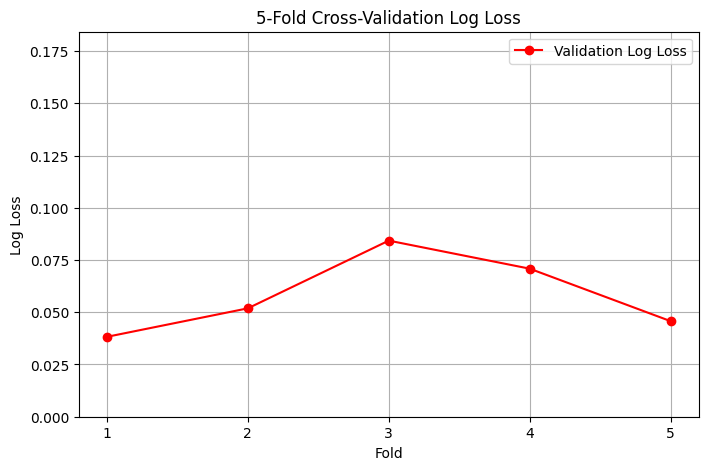

In [28]:
fold_losses = []  # Store log loss values

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]
    model = SVC(probability=True)
    parameters = [{'gamma':[0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]
    gread_search = GridSearchCV(model, parameters)
    gread_search.fit(X_train_fold, y_train_fold)
    # model = RandomForestClassifier()
    # model.fit(X_train_fold, y_train_fold)

    y_val_proba = gread_search.best_estimator_.predict_proba(X_val_fold)
    fold_loss = log_loss(y_val_fold, y_val_proba)

    fold_losses.append(fold_loss)  # Store loss
    print(f"Fold {fold} Log Loss: {fold_loss:.4f}")

# Plot Log Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(fold_losses) + 1), fold_losses, marker='o', linestyle='-', color='r', label='Validation Log Loss')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.title(f'{n_splits}-Fold Cross-Validation Log Loss')
plt.ylim(0, max(fold_losses) + 0.1)  # Keep some margin above max loss
plt.xticks(range(1, len(fold_losses) + 1))
plt.legend()
plt.grid()
plt.show()

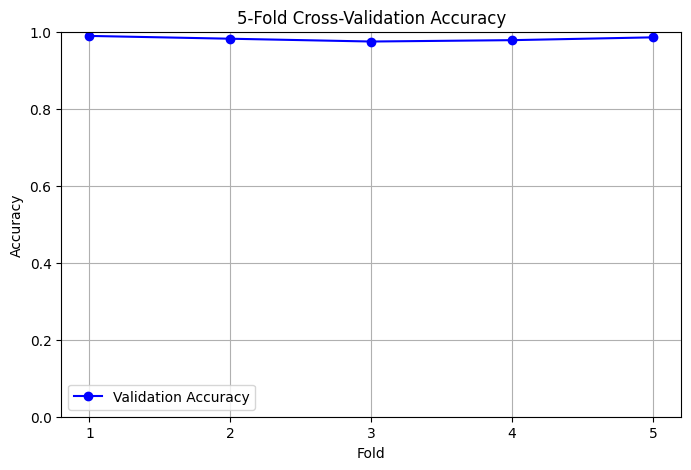

In [22]:
import matplotlib.pyplot as plt

# Plot accuracy across folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_splits + 1), fold_scores, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'{n_splits}-Fold Cross-Validation Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.xticks(range(1, n_splits + 1))
plt.legend()
plt.grid()
plt.show()


NameError: name 'RandomForestClassifier' is not defined

In [19]:


fold_losses = []  # Store log loss values

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]

    model = RandomForestClassifier()
    model.fit(X_train_fold, y_train_fold)

    y_val_proba = model.predict_proba(X_val_fold)  # Get predicted probabilities
    fold_loss = log_loss(y_val_fold, y_val_proba)  # Compute log loss

    fold_losses.append(fold_loss)  # Store loss
    print(f"Fold {fold} Log Loss: {fold_loss:.4f}")

# Plot Log Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(fold_losses) + 1), fold_losses, marker='o', linestyle='-', color='r', label='Validation Log Loss')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.title(f'{n_splits}-Fold Cross-Validation Log Loss')
plt.ylim(0, max(fold_losses) + 0.1)  # Keep some margin above max loss
plt.xticks(range(1, len(fold_losses) + 1))
plt.legend()
plt.grid()
plt.show()



NameError: name 'RandomForestClassifier' is not defined

In [ ]:
# # Perform K-Fold Cross-Validation
# n_splits = 5
# random_state = 42
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# fold_scores = []
# for fold, (train_idx, val_idx) in enumerate(kf.split(X_train), 1):
#     print(f"Training on Fold {fold}...")

#     # Split training data for this fold
#     X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
#     X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

#     # Train model using RandomizedSearchCV
#     random_search.fit(X_train_fold, y_train_fold)
#     best_random_model = random_search.best_estimator_

#     # Train model using GridSearchCV
#     grid_search.fit(X_train_fold, y_train_fold)
#     best_grid_model = grid_search.best_estimator_

#     # Store best model performance for this fold
#     fold_scores.append({
#         "fold": fold,
#         "best_random_params": random_search.best_params_,
#         "best_grid_params": grid_search.best_params_,
#         "random_score": best_random_model.score(X_val_fold, y_val_fold),
#         "grid_score": best_grid_model.score(X_val_fold, y_val_fold)
#     })

# # Print results
# for result in fold_scores:
#     print(f"Fold {result['fold']}:")
#     print(f"  Best RandomizedSearch Params: {result['best_random_params']}")
#     print(f"  Best GridSearch Params: {result['best_grid_params']}")
#     print(f"  RandomizedSearch Score: {result['random_score']:.4f}")
#     print(f"  GridSearch Score: {result['grid_score']:.4f}")

# # Select the best overall model
# best_model = max(fold_scores, key=lambda x: x["grid_score"])["best_grid_params"]
# print(f"\nBest overall model parameters: {best_model}")

In [ ]:
# y_pred = random_search.predict(X_val_fold)
y_pred = gread_search.predict(X_val_fold)
fold_accuracy = accuracy_score(y_val_fold, y_pred)
fold_scores.append(fold_accuracy)
print(f"Fold {fold} Accuracy: {fold_accuracy:.4f}")
# print(f"Accuracy: {accuracy}")

print("\nDetailed classification report:")
print(classification_report(y_val_fold, y_pred, target_names=categories))

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy across folds
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_splits + 1), fold_scores, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title(f'{n_splits}-Fold Cross-Validation Accuracy')
plt.ylim(0, 1)  # Accuracy is between 0 and 1
plt.xticks(range(1, n_splits + 1))
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val_fold, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:

# Calculate mean and std of CV scores
cv_mean = np.mean(fold_scores)
cv_std = np.std(fold_scores)
print(f"\nCross-validation Mean Accuracy: {cv_mean:.4f} (±{cv_std:.4f})")

# Train final model on all training data and evaluate on validation set
model.fit(X_train, y_train)
val_score = accuracy_score(y_val, model.predict(X_val))
test_score = accuracy_score(y_test, model.predict(X_test))

print(f"Validation Set Accuracy: {val_score:.4f}")
print(f"Test Set Accuracy: {test_score:.4f}")


In [ ]:
cv=5
n_points=10
# Generate training set sizes
train_sizes = np.linspace(0.1, 1.0, n_points)
train_scores = []
val_scores = []

for size in train_sizes:
    n_samples = int(len(X_train) * size)

    # Perform CV for this training size
    cv_scores = cross_val_score(
        model, X_train[:n_samples], y_train[:n_samples],
        cv=cv, n_jobs=-1
    )

    # Train model on this subset and evaluate on validation set
    model.fit(X_train[:n_samples], y_train[:n_samples])
    val_score = model.score(X_val, y_val)

    train_scores.append(cv_scores)
    val_scores.append(val_score)

train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Calculate means and stds
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = val_scores

# Plot learning curves
plt.figure(figsize=(10, 6))

plt.plot(train_sizes * len(X_train), train_mean,
         label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes * len(X_train),
                 train_mean - train_std, train_mean + train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes * len(X_train), val_mean,
         label='Validation Score', color='green', marker='o')

plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='lower right')
plt.grid(True)

# Add final scores text box
plt.text(0.02, 0.02,
         f'Final Training Score: {train_mean[-1]:.4f}\n'
         f'Final Validation Score: {val_mean[-1]:.4f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
